In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
from joblib import Parallel, delayed
import multiprocessing, pathos

import numba
from numba import jit

Serial time 4.3191118240356445


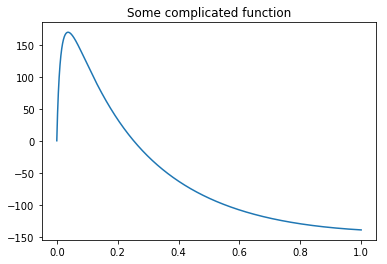

CPU times: user 4.72 s, sys: 346 ms, total: 5.06 s
Wall time: 4.46 s


In [2]:
%%time
def very_math(x):
     return np.sum([np.sin(np.log(i*x+1)) for i in range(2, 200)], axis=0)
    
data = np.linspace(0, 1, 10000)

def do_job_serial(data):
    N = data.shape[0]
    rez = np.zeros(N)
    for j in range(N):
        rez[j] = very_math(data[j])
    return rez

#%timeit very_math(1)

t = time()
results_serial = do_job_serial(data)
print("Serial time", time()-t)

plt.figure()
plt.plot(data, results_serial)
plt.title('Some complicated function')
plt.show()

## Multiprocessing

There is significant gain up to 4 cores. The additional (logical) cores do not contribute to any performance enhancement, since they share resources.

**Problems**:
  * Uses Pickle to store function before parallel execution. Non-top level functions can't be Pickled. So it is not very useful for parallelizing external libraries

In [3]:
for NCore in range(1, multiprocessing.cpu_count()):
    t = time()
    pool = multiprocessing.Pool(NCore)
    results_mp = pool.map(very_math, data)

    print("NCore", NCore, "Parallel time", time() - t, "Error:", np.linalg.norm(results_mp - results_serial))

NCore 1 Parallel time 4.485529184341431 Error: 0.0
NCore 2 Parallel time 2.3677289485931396 Error: 0.0
NCore 3 Parallel time 1.5538232326507568 Error: 0.0
NCore 4 Parallel time 1.223675012588501 Error: 0.0
NCore 5 Parallel time 1.1992013454437256 Error: 0.0
NCore 6 Parallel time 1.2404968738555908 Error: 0.0
NCore 7 Parallel time 1.2023987770080566 Error: 0.0


## Pathos

Solves problem of Multiprocessing by having better pickling strategies

In [4]:
for NCore in range(1, multiprocessing.cpu_count()):
    t = time()
    pool = pathos.multiprocessing.ProcessingPool(NCore)
    results_mp = pool.map(very_math, data)

    print("NCore", NCore, "Parallel time", time() - t, "Error:", np.linalg.norm(results_mp - results_serial))

NCore 1 Parallel time 4.803663730621338 Error: 0.0
NCore 2 Parallel time 2.5578012466430664 Error: 0.0
NCore 3 Parallel time 1.6958465576171875 Error: 0.0
NCore 4 Parallel time 1.404219150543213 Error: 0.0
NCore 5 Parallel time 1.3871548175811768 Error: 0.0
NCore 6 Parallel time 1.3955540657043457 Error: 0.0
NCore 7 Parallel time 1.354231595993042 Error: 0.0


## Joblib

AKA complete junk

In [5]:
t = time()
results_joblib = Parallel(n_jobs=-1, backend="threading")(map(delayed(very_math), data))
print("Parallel time", time()-t)

print("Difference:", np.linalg.norm(results_joblib-results_serial))

Parallel time 13.239097118377686
Difference: 0.0


## Numba

It works! Just need to convert all functions to numba, and avoid using lists.

**Problems**:
  * All functions must essentially be Numpy. If the function uses 3rd party library (e.g. SciPy), it can't be converted to CPython using Numba scripts.

In [6]:
@jit(nopython=True)
def very_math_numba(x):
    rez = 0
    for i in range(2, 200):
        rez += np.sin(np.log(i)*x)
    return rez
    
@jit(nopython=True)
def do_job_numba(data):
    N = data.shape[0]
    rez = np.zeros(N)
    for j in range(N):
        rez[j] = very_math_numba(data[j])
    return rez
    
%timeit very_math_numba(1)
    
t = time()
results_numba = do_job_numba(data)
print("Parallel time", time()-t)

print("Difference:", np.linalg.norm(results_numba-results_serial))

7.31 µs ± 39.9 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
Parallel time 0.15251588821411133
Difference: 15553.493548997603


In [53]:
print(numba.__version__)

0.42.0
